In [4]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function Broyden(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HBFGS, BBFGS = BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HDFP, BDFP = DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    Hₖ = (1-ϕ)*HDFP + ϕ*HBFGS
    Bₖ = inv(Hₖ)
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

Broyden (generic function with 1 method)

In [5]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [6]:
function lineSearch(problem, x₀, Δ; affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    pₖ = zeros(length(x₀))
    sₖ = zeros(length(x₀))
    yₖ = zeros(length(x₀))
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    B = problem.Hess(x₀)
    NormP = []
    P = [] 
    NormB = [norm(Bₖ - B)] 
    F = [] 
    eig = []
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ, ϕ)
            push!(NormB, norm(Bₖ - B))
            push!(eig, real.(eigvals(Bₖ)))
        end
        dₖ = -Hₖ*gₖ # Direction de descente
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, αₖ)
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(P, pₖ)  
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, P, NormB, F, eig, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(P, pₖ) 
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k - 1, P, NormB, F, eig, α, G)
end

lineSearch (generic function with 1 method)

In [39]:
 function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true, CGtype = 1)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    X = []
    normP = []
    F = []
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= ϵ && negCurvature)
            if(dot(rₖ, pₖ) < ϵ)
                αₖ = 2*Δ/norm(pₖ) # On force à sortir de la région de confiance
            else
                αₖ = -2*Δ/norm(pₖ)
            end
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, αₖ)
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G)
        end
        yₖ = αₖ * bₖ
        # Les différents βₖ possibles
        if(CGtype == 2)
            βₖ = 1/dot(rₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 3)
            βₖ = 1/dot(rₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, yₖ)
        elseif(CGtype == 4)
            βₖ = -1/dot(pₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 5)
            βₖ = -1/dot(pₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, yₖ)
        elseif(CGtype == 6)
            βₖ = 1/dot(pₖ, yₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 7)
            rₖ = problem.gradient(xₖ)
            βₖ = dot(rₖ/dot(pₖ, yₖ), yₖ - 2*pₖ*dot(yₖ, yₖ) / dot(pₖ, yₖ))
        else
            rₖ = problem.gradient(xₖ)
            βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        end            
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k, normP, F, α, G)
end

CG (generic function with 1 method)

[2.56832e7, 1.56983e8, 5.72399e8, 1.03537e9, 2.10941e9, 2.69444e9, 4.55584e9, 5.63452e9, 6.42202e9, 1.10542e10, 1.16747e10, 1.29184e10, 1.42983e10, 1.7453e10, 2.43533e10, 2.53717e10, 2.63244e10, 3.17939e10, 3.67664e10, 3.8606e10, 4.18289e10, 5.46063e10, 5.86713e10, 6.03496e10, 6.8622e10, 7.60963e10, 7.92016e10, 8.26779e10, 9.53948e10, 1.01798e11, 1.07765e11, 1.13963e11, 1.16905e11, 1.19978e11, 1.25832e11, 1.42255e11, 1.45792e11, 1.57665e11, 1.63226e11, 1.68097e11, 1.7897e11, 1.86785e11, 2.03651e11, 2.05646e11, 2.17257e11, 2.30382e11, 2.34758e11, 2.43395e11, 2.51186e11, 2.61539e11, 2.68687e11, 2.9285e11, 3.07312e11, 3.21569e11, 3.33436e11, 3.39563e11, 3.5209e11, 3.62554e11, 3.73443e11, 3.87028e11, 4.06323e11, 4.13357e11, 4.33004e11, 4.44671e11, 4.67492e11, 4.70405e11, 4.96225e11, 5.152e11, 5.3103e11, 5.39508e11, 5.43658e11, 5.81201e11, 5.89127e11, 5.89642e11, 6.21887e11, 6.26279e11, 6.41414e11, 6.59956e11, 6.86309e11, 7.08513e11, 7.35302e11, 7.3824e11, 7.64361e11, 7.6889e11, 7.77702e11,

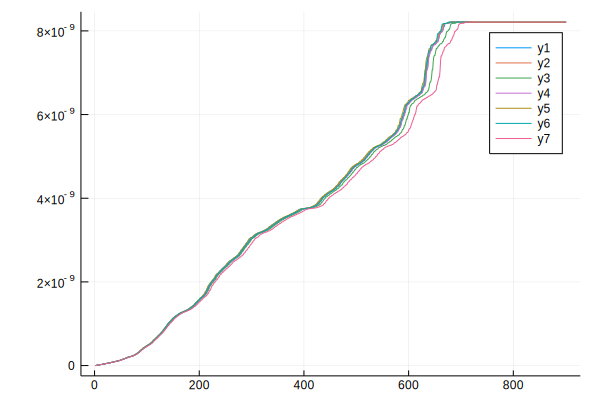

In [40]:
N = 300
A = rand(3000:400000, N, N)
b = rand(N)
A = A' * A
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
quad = problem(f, g, B)
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))

nC = false
Δ = Inf
sol, k₁, normP₁, F₁, α, G₁ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 1,maxiter = 3*N)
sol, k₂, normP₂, F₂, α, G₂ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 2,maxiter = 3*N)
sol, k₃, normP₃, F₃, α, G₃ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 3,maxiter = 3*N)
sol, k₄, normP₄, F₄, α, G₄ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 4,maxiter = 3*N)
sol, k₅, normP₅, F₅, α, G₅ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 5,maxiter = 3*N)
sol, k₆, normP₆, F₆, α, G₆ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 6,maxiter = 3*N)
sol, k₇, normP₇, F₇, α, G₇ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 7,maxiter = 3*N)

plot(1:k₁, normP₁)
plot!(1:k₂, normP₂)
plot!(1:k₃, normP₃)
plot!(1:k₄, normP₄)
plot!(1:k₅, normP₅)
plot!(1:k₆, normP₆)
plot!(1:k₇, normP₇)

In [21]:
N = 6
# d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
# d = [3, 4, 10, 3, 2, 10]
d = [3, 10, 7, 2, 5, 9]
# d = [1, 1, 1, 1, 1, 1]
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement (décrochage de SR1)
# d = [10e-5, 8, 4e3, 3e5, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-singulière avec gros contionemment (1) (décallage de CG)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-singulière avec gros contionemment (2) (décrochage de BFGS)
# d = [0.015, 3.5, -0.15, -0.25, 0.95, 111.5] # Exemple où la norme de p n'est pas croissante
# d = [0.015, 3.5, 15, 25, 0.0095, -111.5] # Exemple où l'erreur de ||Bₖ - B|| pour BFGS augmente avec SR1
# d = [-0.015, 3.5, -15, 25, -0.0095, 111.5] # Exemple où BFGS meilleur que SR1
# d = [-0.015, 3.5, 15, 25, -0.0095, 111.5] # Exemple où SR1 produit une direction ascendante à la fin (avec negCurvature = false)
# d = [3000, -4000, -3000, -0.250, 0.25, 4000] # Yoyo
d = [-1, 0.9, -0.8, 0.15, 3.1, 3] # SR1 : alpha > 0 alors que courbure négative
# N, d = 8, [15, 30, 20, 45, -50, 35, 42, 75]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)

problem(f, g, B)

In [6]:
n = 5
m = 5
N = n + m
M = rand(-1:0.01:1, n, n)
@test det(M) != 0
M = transpose(M)*M
C = rand(-1:0.01:1, m, m)
@test det(C) != 0
C = transpose(C)*C
K = rand(-1:0.01:1, n, m)
A = zeros(n+m, n+m)
A[1:n, 1:n] = M
A[(n+1):(n+m), 1:n] = transpose(K)
A[1:n, (n+1):(n+m)] = K
A[(n+1):(n+m), (n+1):(n+m)] = -C;

b = zeros(n + m)
b[1:n] = rand(-10:0.1:10, n);

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(n + m)
quadratic = problem(f, g, B)

problem(f, g, B)

In [7]:
b = [1, -1]
A = [-1 0; 0 1]
println(eigvecs(A))

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(2)
quadratic = problem(f, g, B)

[1.0 0.0; 0.0 1.0]


problem(f, g, B)

conditionnement de la Hessienne : 31.962290164513494
determinant de A : 1.004400000000001

Méthode BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ||    ||gₖ||        ρₖ 
   0  1.6e+00 -9.7e-01  6.0e-01 -2.9e-01  6.0e-01  4.0e+00  9.9e-01      Inf 
   1 -8.7e-01 -1.0e+00 -1.2e+00  3.1e-01  1.3e+00  3.7e+00  1.0e+00  1.7e+00 
   2  4.7e-01 -7.8e-01  1.6e+00 -3.3e-01  1.6e+00  2.9e+00  8.8e-01 -8.3e-01 
   3  2.5e-01 -4.7e-01  1.9e+00 -7.7e-01  3.3e+00  2.8e+00  6.8e-01  7.8e-01 
   4 -6.4e-01 -1.8e+00 -2.8e+00  1.8e+00  9.7e+00  2.6e+00  1.3e+00  1.1e+00 
   5  1.9e+02 -3.1e+01  1.6e-01 -6.7e-01  3.0e+00  5.3e+00  5.6e+00 -2.0e-01 

SR1
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ||    ||gₖ||        ρₖ 
   0  1.6e+00 -9.7e-01  6.0e-01 -2.9e-01  6.0e-01  4.0e+00  9.9e-01      Inf 
   1 -6.5e-02 -2.8e-01 -4.3e+00  3.1e-01  1.3e+00  5.5e+00  1.0e+00  1.7e+00 
   2  2.0e-01 -5.1e-01  2.5e+00 -3.3e-01  1.6e+00  3.0e+00  8.8e-01 -8.3e-01 
   3  1.6e+00 -1.2e+00 

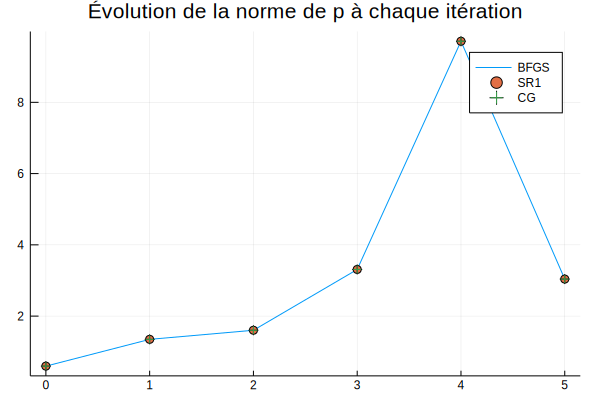

In [18]:
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
#println("eigvals de A : ", real.(eigvals(A)))
println("determinant de A : ", det(A))
println("")

nC = false
Δ = Inf
println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig, α= lineSearch(quadratic, x₀, Δ, maxiter = N+1, ϵ = 10e-12, update = BFGS, negCurvature = nC); 
#println("")
#println("Valeurs propres de Bₖ en fonction des itérations")
#for i = 1:iter
#    println("itération ", i, " : ", eig[i])
#end

println("")
println("SR1")
p₂, NormP₂, iter₂, P₂, normB₂, F₂, eig₂, α₂ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = 10e-12, ϕ = 0.5, update = SR1, negCurvature = nC); 
#println("")
#println("Valeurs propres de Bₖ en fonction des itérations")
#for i = 1:iter₂
#    println("itération ", i, " : ", eig₂[i])
#end

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ, αᵧ = CG(quadratic, x₀, Δ, maxiter = N + 10, ϵ = 10e-12, negCurvature = nC)

println("")
println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(CG)    p = $pᵧ")
println("(SR1)   p = $p₂")
println("A⁻¹b - x₀ = ", -A\b - x₀)
println("")
@printf("%22s %8.1e \n","(BFGS) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(CG)   ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
@printf("%22s %8.1e \n","(SR1)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
plot(0:iter, NormP, label = "BFGS", title = "Évolution de la norme de p à chaque itération") # legend=:topleft)
plot!(0:iter₂, NormP₂, label = "SR1", marker = :circle, line = false)
plot!(0:(iterᵧ-1), Pᵧ, label = "CG", marker = :cross, line = false)

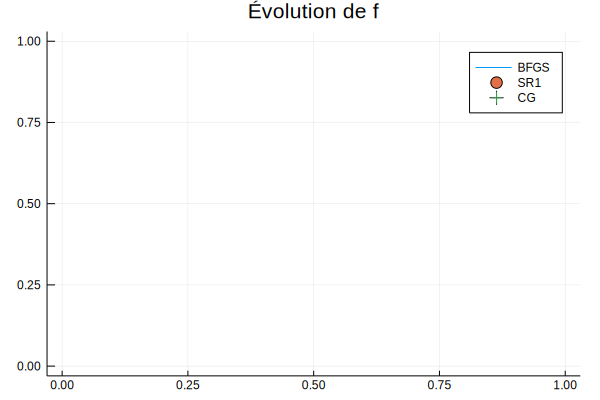

In [9]:
plot(0:iter, F, label = "BFGS", title = "Évolution de f")
plot!(0:iter₂, F₂, label = "SR1", marker = :circle, line = false)
plot!(0:(iterᵧ-1), Fᵧ, label = "CG", marker = :cross, line = false)

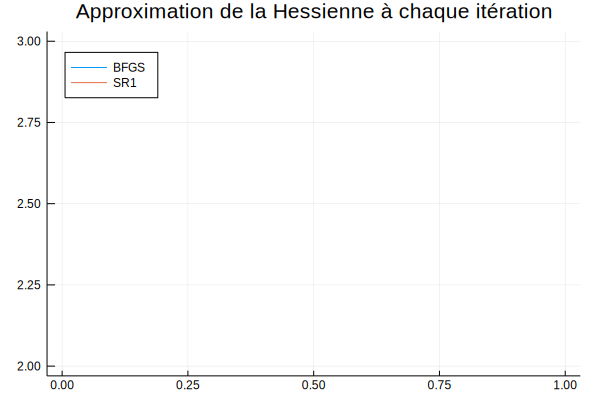

In [10]:
plot(0:iter, normB, label = "BFGS", title = "Approximation de la Hessienne à chaque itération", legend=:topleft) # , yaxis = (:log)
plot!(0:iter₂, normB₂, label = "SR1")

In [30]:
tol = 10e-8
nC = false
Δ = 300
x₀ = 1:10:10*N
println("")
println("Méthode Broyden(0.5)")
p₂, NormP₂, iter₂, P₂, normB₂, F₂, eig₂, α₂ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, ϕ = 1.1, update = Broyden, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₂
    println("itération ", i, " : ", eig₂[i])
end

println("")
println("Méthode Broyden(0.25)")
p₆, NormP₆, iter₆, P₆, normB₆, F₆, eig₆, α₆ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, update = Broyden, ϕ = 0.5, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₆
    println("itération ", i, " : ", eig₆[i])
end

println("")
println("Méthode Broyden(0.75)")
p₅, NormP₅, iter₅, P₅, normB₅, F₅, eig₅, α₅ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, update = Broyden, ϕ = 2, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₅
    println("itération ", i, " : ", eig₅[i])
end

println("")
println("Méthode DFP")
p₃, NormP₃, iter₃, P₃, normB₃, F₃, eig₃, α₃ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, update = DFP, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₃
    println("itération ", i, " : ", eig₃[i])
end

println("")
println("Méthode BFGS")
p₄, NormP₄, iter₄, P₄, normB₄, F₄, eig₄, α₄ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, update = BFGS, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₄
    println("itération ", i, " : ", eig₄[i])
end

println("")
println("Méthode SR1")
p₁, NormP₁, iter₁, P₁, normB₁, F₁, eig₁, α₁ = lineSearch(quadratic, x₀, Δ, maxiter = N, ϵ = tol, update = SR1, negCurvature = nC); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₁
    println("itération ", i, " : ", eig₁[i])
end

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ, αᵧ = CG(quadratic, x₀, Δ, maxiter = N, ϵ = tol, negCurvature = nC);


Méthode Broyden(0.5)
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ||    ||gₖ||        ρₖ 
   0  2.4e+04 -1.4e+04  5.7e-01 -4.6e+03  6.6e+01  4.0e+00  1.2e+02      Inf 
   1 -3.1e+04 -1.7e+04 -5.5e-01  1.2e+02  7.5e+01  3.9e+00  1.3e+02  1.3e-04 
   2  2.0e+02 -2.2e+02  1.1e+00  1.6e+00  7.5e+01  2.8e+00  1.5e+01 -1.1e-04 
   3  7.1e+01 -6.4e+01  9.0e-01 -2.7e+01  7.5e+01  2.7e+00  7.9e+00  4.2e-03 
   4 -3.8e+02 -1.8e+02 -4.7e-01  1.4e+01  7.5e+01  3.1e+00  1.3e+01  1.8e-02 
   5  8.4e-01 -5.0e+00  6.0e+00 -4.1e-01  7.6e+01  8.3e-01  2.2e+00 -1.2e-02 

Valeurs propres de Bₖ en fonction des itérations
itération 1 : [4.39061, 1.0, 0.382378, 1.0, 1.0, 1.0]
itération 2 : [3.09664, -0.995423, 1.0, 0.983179, 1.0, 1.0]
itération 3 : [3.09674, -0.996955, 1.57805, 0.550209, 1.0, 1.0]
itération 4 : [4.78016, 3.09649, -0.997247, 0.166891, 1.13351, 1.0]
itération 5 : [-0.999658, -0.767117, 3.10023, 3.00664, 0.825444, 1.0144]

Méthode Broyden(0.25)
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ    

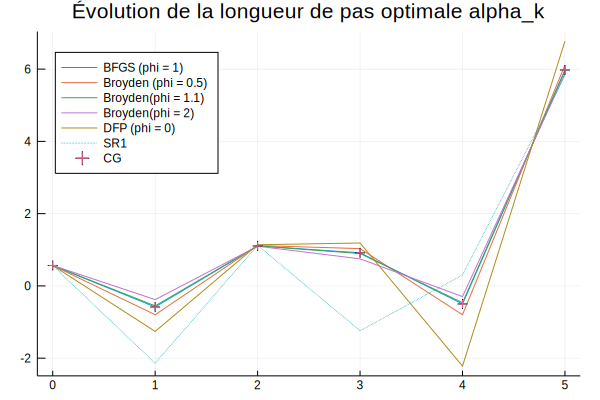

In [31]:
plot(0:iter₄, α₄, label = "BFGS (phi = 1)", title = "Évolution de la longueur de pas optimale alpha_k", legend = :topleft)
plot!(0:iter₆, α₆, label = "Broyden (phi = 0.5)")
plot!(0:iter₂, α₂, label = "Broyden(phi = 1.1)")
plot!(0:iter₅, α₅, label = "Broyden(phi = 2)")
plot!(0:iter₃, α₃, label = "DFP (phi = 0)")
plot!(0:iter₁, α₁, label = "SR1", line = :dot)
plot!(0:(iterᵧ - 1), αᵧ, label = "CG", marker = :cross, line = false)

conditionnement de la Hessienne : 11.976901959837345
eigvals de B : [3.0, 4.0, 5.0, 1.5, 2.0, 10.0]

Méthode BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ||    ||gₖ||        ρₖ 
   0  5.3e+01 -1.4e+01  2.6e-01 -1.8e+00  9.9e-01  1.1e+01  3.7e+00      Inf 
   1  3.8e+00 -1.2e+00  3.1e-01 -2.0e+00  1.1e+00  1.0e+01  1.1e+00  2.7e-01 
   2  4.8e+00 -8.4e-01  1.8e-01 -2.1e+00  1.2e+00  7.2e+00  9.2e-01  2.8e+00 
   3  4.2e-01 -1.0e-01  2.4e-01 -2.1e+00  1.2e+00  4.2e+00  3.2e-01  6.7e+00 
   4  1.0e-02 -4.3e-03  4.3e-01 -2.1e+00  1.2e+00  2.3e+00  6.6e-02  4.2e+01 
   5  5.3e-04 -2.0e-04  3.8e-01 -2.1e+00  1.2e+00  1.6e+00  1.4e-02  5.4e+02 
   6  1.2e-31 -1.2e-31  1.0e+00 -2.1e+00  1.2e+00  1.5e-13  6.8e-16  1.3e+04 
   7  2.5e-32 -5.1e-32  1.0e+01 -2.1e+00  1.2e+00  3.1e+00  5.3e-16  4.7e+30 
   8  1.6e-30 -1.7e-30  1.0e+00 -2.1e+00  1.2e+00  8.7e-01  2.1e-15  3.8e+29 
   9  1.9e-31 -1.5e-31  9.6e-01 -2.1e+00  1.2e+00  8.2e-01  5.1e-16  7.5e+29 
  10  5.2e-32 -1.2e-31 

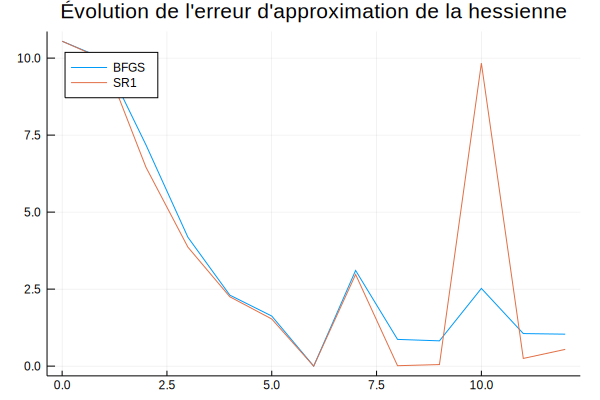

In [40]:
# Déterioration de la matrice Hₖ après n itérations
# d = [3, 4, 10, 3, 2, 10] # 4/6 val propres distinctes
d = [3, 4, 5, 1.5, 2, 10]

D = Diagonal(d)
A = rand(6, 6)
Q, R = qr(A)
A = transpose(Q)*D*Q
b = [1, 2, 3, 0, 0, 0]

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = [0, 0, 0, 0, 0, 0]
quadratic = problem(f, g, B)

println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
println("eigvals de B : ", d)
println("")

Δ = Inf
println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig = lineSearch(quadratic, x₀, Δ, maxiter = 12, ϵ = 10e-30, update = BFGS, negCurvature = false); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter
    println("itération ", i, " : ", eig[i])
end

println("")
Δ = Inf
println("Méthode SR1")
p₂, NormP₂, iter₂, P₂, normB₂, F₂, eig₂ = lineSearch(quadratic, x₀, Δ, maxiter = 12, ϵ = 10e-30, update = SR1, negCurvature = false); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter₂
    println("itération ", i, " : ", eig₂[i])
end

plot(0:iter, normB, label = "BFGS", title = "Évolution de l'erreur d'approximation de la hessienne", legend=:topleft)
plot!(0:iter₂, normB₂, label = "SR1")

In [ ]:
# Avec la contrainte de région de confiance et recherche de minimum sur la frontière
# ... mettre negCurvature = false dans les deux précédents blocks 

conditionnement de la Hessienne : 16.0595013507889736685776843615999385288614323988876824311688552692447539982469
Méthode BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ||    ||gₖ||        ρₖ 
   0  2.0e+03 -1.2e+01  5.9e-03 -3.5e-02  2.0e-02  2.2e+02  3.4e+00      Inf 
   1  9.7e+00 -3.3e+00  3.4e-01 -5.9e-01  7.0e-01  1.5e+01  1.8e+00  1.4e+01 
   2  4.2e+00 -2.0e+00  4.7e-01 -1.1e+00  1.4e+00  1.4e+01  1.4e+00  9.1e-01 
   3  7.2e+00 -3.1e+00  4.3e-01 -1.7e+00  2.8e+00  1.3e+01  1.8e+00  1.1e+00 
   4  4.0e+00 -1.9e+00  4.8e-01 -2.2e+00  3.8e+00  1.3e+01  1.4e+00  7.4e-01 
   5  4.7e+00 -2.1e+00  4.3e-01 -2.6e+00  4.9e+00  1.2e+01  1.4e+00  1.1e+00 
   6  2.8e+00 -1.1e+00  3.9e-01 -2.8e+00  5.5e+00  1.1e+01  1.0e+00  1.1e+00 
   7  1.4e+00 -6.5e-01  4.8e-01 -3.0e+00  6.0e+00  1.0e+01  8.1e-01  2.4e+00 
   8  1.1e+00 -6.6e-01  5.8e-01 -3.2e+00  6.6e+00  9.5e+00  8.1e-01  3.2e+00 
   9  8.8e-01 -5.4e-01  6.2e-01 -3.3e+00  7.2e+00  9.1e+00  7.4e-01  2.6e+00 
  10  1.0e

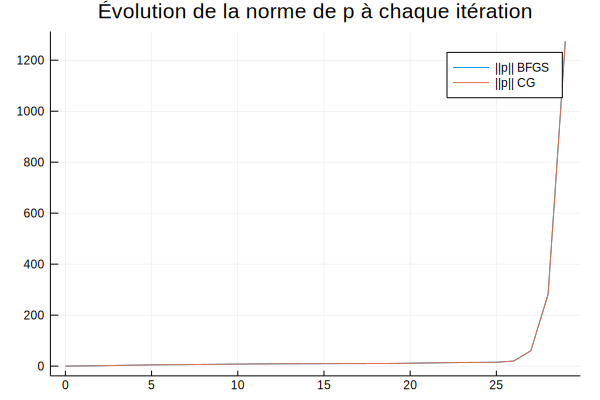

In [40]:
# Problème du gradient conjugué avec un mauvais conditionnement (test en bigfloat)
function createQuadraticConvexe(N = 10)
    b = rand(N)
    C = rand(N, N)
    @test det(C) != 0
    A = transpose(C)*C # Obtention d'une matrice symétrique définie positive (si C non singulier)
    A = BigFloat.(A)
    b = BigFloat.(b)
    f(x) = dot(b, x) + 0.5*dot(x, A*x)
    g(x) = b + A*x
    B(x) = A
    return(problem(f, g, B))
end
# Problème de grande dimension -> BFGS se comporte mieux que CG
N = 30
quadratic = createQuadraticConvexe(N)
x₀ = BigFloat.(zeros(N));
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
# println("valeurs propres de la Hessienne : ", eigvals(A))
Δ = Inf
println("Méthode BFGS")

p, NormP, iter, P, normB, F, eig, α, G = lineSearch(quadratic, x₀, Δ, maxiter = 60, ϵ = 10e-6, update = BFGS, affichage = true); 

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ, αᵧ, Gᵧ = CG(quadratic, x₀, Δ, maxiter = 60, ϵ = 10e-6, affichage = true)

println("")
println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(CG)    p = $pᵧ")
println("")
@printf("%22s %8.1e \n","(BFGS) ||g(x₀ + p)|| = ", norm(quadratic.gradient(x₀ + p)))
@printf("%22s %8.1e \n","(CG)   ||g(x₀ + p)|| = ", norm(quadratic.gradient(x₀ + pᵧ)))
plot(0:iter, NormP, label = "||p|| BFGS", title = "Évolution de la norme de p à chaque itération")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")

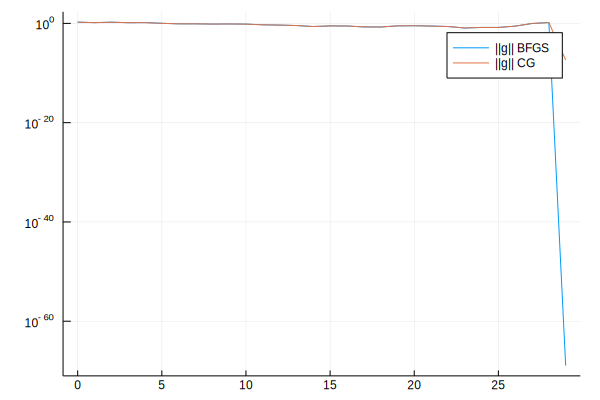

In [43]:
plot(0:iter, G, label = "||g|| BFGS", yaxis = :log)
plot!(0:(iterᵧ-1), Gᵧ, label = "||g|| CG")

In [114]:
N = 100
A = rand(N, N)
b = rand(N)
A = A' * A
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))
println("A⁻¹b - x₀ = ", -A\b)

nC = false
Δ = Inf
println("")
println("Méthode SR1")
p₂, NormP₂, iter₂, P₂, normB₂, F₂, eig₂ = lineSearch(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-8, update = DFP, negCurvature = nC); 
println("")
println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig = lineSearch(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-8, update = BFGS, negCurvature = nC); 
println("")
println("Méthode CG")
pᵧ, iterᵧ, Pᵧ, Fᵧ, αᵧ, Gᵧ = CG(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-8, negCurvature = nC); 

println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(SR1)   p = $p₂")

norm(A)*norm(inv(A))

[0.000294252, 0.00658936, 0.0157417, 0.0200492, 0.0292738, 0.0702103, 0.0816221, 0.0928633, 0.101088, 0.18106, 0.230306, 0.232538, 0.286351, 0.406472, 0.451281, 0.492908, 0.530087, 0.589074, 0.727945, 0.771683, 0.883498, 0.915423, 1.01279, 1.15742, 1.25435, 1.32487, 1.41999, 1.51516, 1.7829, 1.87625, 1.98731, 2.08509, 2.21502, 2.38754, 2.58381, 2.69286, 2.86261, 3.08019, 3.24112, 3.46785, 3.55461, 3.78954, 3.87609, 3.95973, 4.167, 4.37796, 4.42905, 4.94284, 5.02083, 5.13394, 5.49326, 5.90406, 6.15649, 6.41744, 6.58572, 6.80555, 7.27181, 7.63771, 7.86656, 8.00233, 8.15352, 8.51485, 8.84796, 8.98525, 9.28065, 9.74213, 9.91731, 10.6251, 10.9555, 11.1962, 11.6199, 12.0474, 12.7159, 13.145, 13.6253, 13.9527, 14.4851, 14.7283, 15.164, 15.3792, 16.2515, 16.6621, 17.3205, 17.8059, 19.1908, 19.3581, 20.0176, 20.364, 21.4541, 21.729, 22.3913, 22.682, 24.0819, 24.6057, 25.9946, 26.5579, 27.5034, 28.4991, 30.2677, 2527.24]
A⁻¹b - x₀ = [12.8837, 32.5947, 12.0251, 13.5906, 32.6853, -7.65263, -3.1536

  81  3.2e-05 -2.7e-03  8.3e+01 -6.3e+00  5.2e+01  1.7e+02  6.8e-01  3.3e+00 
  82  5.4e-05 -2.6e-03  4.9e+01 -6.4e+00  5.4e+01  8.2e+01  4.7e-01  4.5e+00 
  83  2.8e-05 -2.6e-03  9.4e+01 -6.5e+00  5.8e+01  8.7e+01  4.8e-01  7.8e+00 
  84  2.9e-05 -2.6e-03  9.0e+01 -6.6e+00  6.3e+01  1.2e+02  5.5e-01  4.1e+00 
  85  3.6e-05 -2.6e-03  7.1e+01 -6.7e+00  6.6e+01  9.3e+01  4.9e-01  4.3e+00 
  86  3.7e-05 -2.5e-03  6.8e+01 -6.8e+00  6.9e+01  6.1e+01  4.0e-01  5.5e+00 
  87  4.0e-05 -2.5e-03  6.2e+01 -6.9e+00  7.2e+01  8.3e+01  4.6e-01  5.8e+00 
  88  5.4e-05 -2.4e-03  4.5e+01 -6.9e+00  7.4e+01  4.6e+01  3.4e-01  6.4e+00 
  89  2.6e-05 -2.4e-03  9.3e+01 -7.0e+00  7.8e+01  4.9e+01  3.4e-01  9.1e+00 
  90  2.9e-05 -2.4e-03  8.0e+01 -7.1e+00  8.2e+01  1.1e+02  5.1e-01  4.5e+00 
  91  1.6e-05 -2.3e-03  1.4e+02 -7.3e+00  8.8e+01  1.0e+02  4.9e-01  5.2e+00 
  92  2.6e-05 -2.3e-03  8.7e+01 -7.4e+00  9.2e+01  4.1e+01  3.1e-01  3.0e+00 
  93  1.6e-05 -2.2e-03  1.4e+02 -7.6e+00  9.8e+01  4.7e+01  3.3e

  86  1.4e-01 -1.6e-01  1.1e+00 -6.8e+00  6.9e+01  4.8e+00  4.0e-01  5.5e+00 
  87  2.8e-01 -2.1e-01  7.4e-01 -6.9e+00  7.2e+01  4.3e+00  4.6e-01  5.8e+00 
  88  1.2e-01 -1.2e-01  9.5e-01 -6.9e+00  7.4e+01  3.9e+00  3.4e-01  6.4e+00 
  89  6.2e-02 -1.2e-01  1.9e+00 -7.0e+00  7.8e+01  3.6e+00  3.4e-01  9.1e+00 
  90  3.7e-01 -2.6e-01  7.2e-01 -7.1e+00  8.2e+01  3.1e+00  5.1e-01  4.5e+00 
  91  1.7e-01 -2.4e-01  1.4e+00 -7.3e+00  8.8e+01  2.2e+00  4.9e-01  5.2e+00 
  92  4.6e-02 -9.6e-02  2.1e+00 -7.4e+00  9.2e+01  2.1e+00  3.1e-01  3.0e+00 
  93  3.7e-02 -1.1e-01  2.9e+00 -7.6e+00  9.8e+01  2.1e+00  3.3e-01  5.0e+00 
  94  1.3e-01 -3.4e-01  2.6e+00 -8.0e+00  1.2e+02  1.8e+00  5.8e-01  3.2e+00 
  95  1.0e-01 -3.4e-01  3.4e+00 -8.6e+00  1.4e+02  1.7e+00  5.8e-01  1.1e+00 
  96  4.5e-02 -9.4e-02  2.1e+00 -8.7e+00  1.4e+02  1.6e+00  3.1e-01  8.6e-01 
  97  1.9e-03 -3.6e-02  1.9e+01 -9.0e+00  1.6e+02  1.5e+00  1.9e-01  5.1e+00 
  98  2.2e-03 -3.4e-02  1.5e+01 -9.3e+00  1.7e+02  1.2e+00  1.9e

 121 -4.9e-01  9.8e-02 -6.7e+00  6.5e+01  7.0e-01  7.5e-01 
 122 -4.4e-01  2.6e-01 -6.7e+00  6.7e+01  6.6e-01  8.9e-01 
 123 -6.9e-01  7.1e-04 -6.7e+00  6.7e+01  8.3e-01  1.6e+00 
 124 -5.4e-01  9.5e-02 -6.7e+00  6.8e+01  7.4e-01  7.9e-01 
 125 -4.2e-01  2.2e-01 -6.8e+00  6.9e+01  6.5e-01  7.8e-01 
 126 -2.6e-01  2.1e-01 -6.8e+00  7.0e+01  5.1e-01  6.2e-01 
 127 -6.8e-01  1.4e-01 -6.9e+00  7.2e+01  8.2e-01  2.6e+00 
 128 -3.8e-01  8.8e-02 -6.9e+00  7.3e+01  6.2e-01  5.6e-01 
 129 -4.2e-01  7.9e-04 -6.9e+00  7.3e+01  6.5e-01  1.1e+00 
 130 -4.2e-01  1.9e-01 -6.9e+00  7.4e+01  6.5e-01  1.0e+00 
 131 -2.2e-01  1.4e-01 -6.9e+00  7.5e+01  4.7e-01  5.4e-01 
 132 -2.3e-01  7.2e-01 -7.0e+00  7.8e+01  4.8e-01  1.0e+00 
 133 -6.2e-01  8.8e-02 -7.1e+00  7.9e+01  7.9e-01  2.7e+00 
 134 -4.3e-01  2.8e-01 -7.1e+00  8.1e+01  6.6e-01  7.0e-01 
 135 -9.9e+00  4.6e-04 -7.1e+00  8.1e+01  3.1e+00  2.3e+01 
 136 -1.2e+00  1.3e-01 -7.2e+00  8.5e+01  1.1e+00  1.2e-01 
 137 -2.8e-01  2.5e-01 -7.2e+00  8.6e+01

8.609298488178812e6

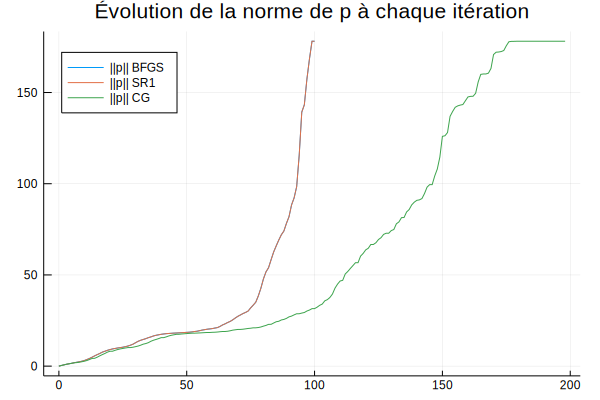

In [115]:
plot(0:iter, NormP, label = "||p|| BFGS", title = "Évolution de la norme de p à chaque itération", legend = :topleft)
plot!(0:iter₂, NormP₂, label = "||p|| SR1")

plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")

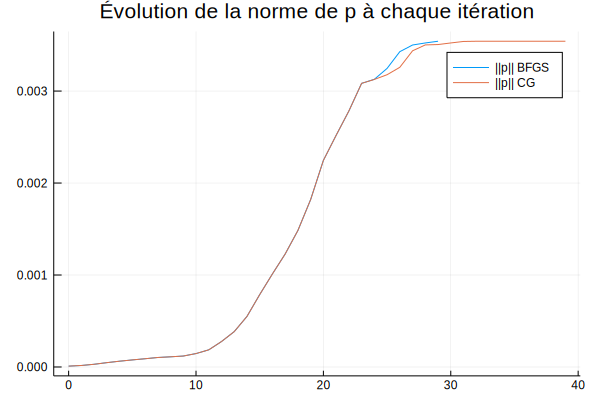

In [101]:
plot(0:iter, NormP, label = "||p|| BFGS", title = "Évolution de la norme de p à chaque itération")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")